# Sentiment Pipeline

## Twitter Helpers

In [220]:
import twitter
import pickle, os

def get_api():
    return twitter.Api(
        consumer_key='hqIQaE6RCC3Z5Jm8pCuWPPwPV',
        consumer_secret='MJBNLyftcozaC8C9l0phboaemgStv3eGQ8s4UfEsy8hh9tBnsK',
        access_token_key='775764899251314688-wnHTmMY9hv9MtLS3uL4kFfMi3cY45yD',
        access_token_secret='nyMf6qOMklFe0f1e74j1ZLgpxbaKL3YGIbMOzcCd9eebK')

def search(api, q, count=200, lang="en", result_type="mixed"):
    query = f'q={q}&result_type={result_type}&count={count}&lang={lang}'
    if in_cache(query):
        return load_from_cache(query)
    result = api.GetSearch(raw_query=query)
    save_to_cache(query, result)
    
def load_from_cache(name):
    with open(f'./cache/{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
    return obj

def save_to_cache(name, obj):
    with open(f'./cache/{name}.pkl', 'wb') as f:
        pickle.dump(obj, f)

def in_cache(name):
    if f'{name}.pkl' in os.listdir('./cache'):
        return True
    return False

## Get NYC Neighborhood NTAs

In [3]:
import pandas as pd

def get_nyc_ntas(limit=None):
    df = pd.read_csv('./data/nynta.csv')
    return list(df['NTAName'])[:limit]

get_nyc_ntas()

['Borough Park',
 'Murray Hill',
 'East Elmhurst',
 'Hollis',
 'Manhattanville',
 'Homecrest',
 'Westchester-Unionport',
 'Pelham Bay-Country Club-City Island',
 'Schuylerville-Throgs Neck-Edgewater Park',
 'Fresh Meadows-Utopia',
 'St. Albans',
 'Corona',
 'Jamaica Estates-Holliswood',
 'Madison',
 'Kensington-Ocean Parkway',
 'Erasmus',
 'Longwood',
 'Clinton Hill',
 'Cambria Heights',
 'Midwood',
 'Jamaica',
 'South Jamaica',
 'Gravesend',
 'Bensonhurst East',
 'Williamsburg',
 'Bedford',
 'Stuyvesant Heights',
 'Ocean Parkway South',
 'Ocean Hill',
 'Crown Heights North',
 'Crown Heights South',
 'Rugby-Remsen Village',
 'Allerton-Pelham Gardens',
 'Starrett City',
 'East Flatbush-Farragut',
 'Ridgewood',
 'Bushwick South',
 'Bushwick North',
 'Fort Greene',
 'Queensbridge-Ravenswood-Long Island City',
 'West Farms-Bronx River',
 'Parkchester',
 'Soundview-Bruckner',
 'Dyker Heights',
 'West Brighton',
 'Rego Park',
 'Glendale',
 'Van Cortlandt Village',
 'North Corona',
 'Pomonok-

## Harvest Tweets

In [225]:
from datetime import datetime

def get_tweets_for_nyc_ntas(limit=None):
    api = get_api()
    results = {}
    nta_names = get_nyc_ntas(limit=limit)
    for nta in nta_names:
        results[nta] = search(api, nta)
    return results

def get_nyc_ntas_tweets_df(results):
    data = {'nta': [], 'tweet_id': [], 'created_at': [], 'content': []}
    for nta in results:
        for tweet in results[nta]:
            data['nta'].append(nta)
            data['tweet_id'].append(tweet.id)
            data['created_at'].append(
                datetime.fromtimestamp(tweet.created_at_in_seconds).strftime("%Y/%m/%d, %H:%M:%S"))
            data['content'].append(tweet.text)
    return pd.DataFrame(data)
        

results = get_tweets_for_nyc_ntas(limit=52)
df = get_nyc_ntas_tweets_df(results)
df.head()

,nta,tweet_id,created_at,content
0,Borough Park,1236660460986028035,"2020/03/08, 10:30:04",#NewYork #Manhattan borough from space!\nA gli...
1,Borough Park,1234866987324624896,"2020/03/03, 10:43:27",Work on the Cycleway between Highbury Fields a...
2,Borough Park,1236874522575454209,"2020/03/09, 00:40:40",RT @SwkHeritage: Councillor Jessie Burgess was...
3,Borough Park,1236872823097958400,"2020/03/09, 00:33:55",@JnthnMorse @BroodingHamlet @DouglasKMurray I ...
4,Borough Park,1236794541128200194,"2020/03/08, 19:22:51",@realDonaldTrump Many Illegal live in Brooklyn...


## Analyzing Sentiment

In [231]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pycorenlp import StanfordCoreNLP
import numpy as np

def get_vader_analyzer():
    return SentimentIntensityAnalyzer()

def get_vader_sentiment(analyzer, sentence, compound=True):
    if compound:
        return analyzer.polarity_scores(sentence)['compound']
    return analyzer.polarity_scores(sentence)

def get_stanford_nlp():
    # java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000
    return StanfordCoreNLP('http://localhost:9000')

def get_stanford_sentiment(nlp, sentence, sum_product=True):
    properties = {'annotators': 'sentiment', 'outputFormat': 'json', 'timeout': 30000}
    res = nlp.annotate(sentence, properties=properties)
    if sum_product:
        dist = res['sentences'][0]['sentimentDistribution']
        return np.dot(np.array(dist), np.array([0, 1, 2, 3, 4]))
    return int(res['sentences'][0]['sentimentValue'])

def attach_sentiment(df):
    vader_analyzer = get_vader_analyzer()
    stanford_nlp = get_stanford_nlp()
    df['vader_sent'] = df['content'].apply(lambda x: get_vader_sentiment(vader_analyzer, x))
    df['stanford_sent'] = df['content'].apply(lambda x: get_stanford_sentiment(stanford_nlp, x))
    return df

def normalize_stanford_sentiment(df):
    df['norm_stanford_sent'] = df['stanford_sent'].apply(lambda x: float(x - 2) / 2)
    return df

# WILL TAKE A LONG TIME ... CAUTION.
df = attach_sentiment(df)
df = normalize_stanford_sentiment(df)

In [301]:
df.sample(5)

,nta,tweet_id,created_at,content,vader_sent,stanford_sent,norm_stanford_sent
2394,Parkchester,1235618223325921280,"2020/03/05, 12:28:35",MACHINE FIXED: An escalator @ Parkchester serv...,0.0000,1.268574,-0.365713
2964,Clinton,1236885695698010112,"2020/03/09, 01:25:04",RT @HillaryClinton: Forward movement will alwa...,0.0000,2.337460,0.168730
1669,Williamsburg,1236875211091435522,"2020/03/09, 00:43:25",RT @Rachel_Sennott: I love to walk on the Will...,0.8779,2.363913,0.181957
2871,North Corona,1236857127265804288,"2020/03/08, 23:31:33",RT @timesofindia: Italy locks down most of its...,0.0422,1.218137,-0.390932
1836,Bedford,1236858144904511488,"2020/03/08, 23:35:36",RT @CT_Bergstrom: The openness and humility in...,0.8612,3.206763,0.603381


## Visualizing Results

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def get_sentiment_histogram_by_nta(df, ntas, method='stanford'):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    colors = ['red', 'blue']
    for i in range(len(ntas)):
        color = colors[i % len(colors)]
        df_nta = df[df['nta'] ==  ntas[i]]
        if method == 'vader' or method == 'both': 
            ax.hist(df_nta['vader_sent'], bins=np.arange(-1, 1, 0.1), alpha=0.3, color=color, label=ntas[i])
        if method == 'stanford' or method == 'both': 
            ax.hist(df_nta['norm_stanford_sent'], bins=np.arange(-1, 1, 0.1), alpha=0.3, color=color, label=ntas[i])
    ax.set_xlim(-1, 1)
    ax.set_title(f'Sentiment Distribution')
    ax.set_xlabel(f'Normalized Sentiment (method = {method})')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()

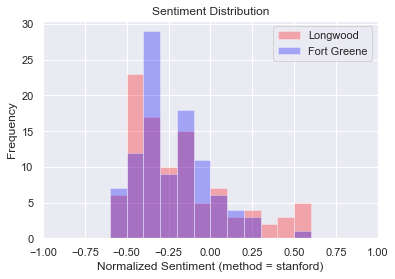

In [296]:
get_sentiment_histogram_by_nta(df, ['Longwood', 'Fort Greene'], method='stanford')

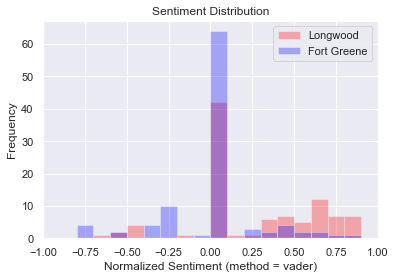

In [292]:
get_sentiment_histogram_by_nta(df, ['Longwood', 'Fort Greene'], method='vader')